In [2]:
import copy
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision.transforms import transforms
import torchvision.models as models

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Load data

In [4]:
img_size = 128

def img_loader(img_path, device, img_size):
    # Compose is used to combine multiple transforms
    loader = transforms.Compose([transforms.Resize(img_size), transforms.ToTensor()])
    img = Image.open(img_path)
    img = img.resize((img_size, img_size))
    # add batch dim
    # (img_size, img_size, 3) => (1, img_size, img_size, 3)
    img = loader(img).unsqueeze(0)
    return img.to(device, torch.float)

In [6]:
style_img = img_loader("data/style.jpg", device, img_size)
content_img = img_loader("data/content.jpg", device, img_size)

In [7]:
def img_show(img_tensor, title=None):
    unloader = transforms.ToPILImage()

    img = img_tensor.cpu().clone()
    img = img.squeeze(0) # remove batch dim
    img = unloader(img)

    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

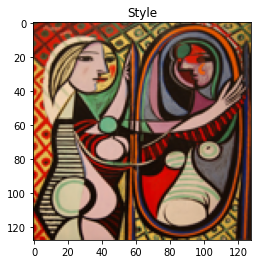

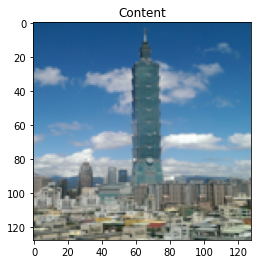

In [8]:
%matplotlib inline
plt.figure()
img_show(style_img, title="Style")
plt.figure()
img_show(content_img, title="Content")

In [9]:
# normalization img for vgg model
vgg_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
vgg_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super().__init__()
        self.mean = mean.clone().detach().view(-1, 1, 1)
        self.std = std.clone().detach().view(-1, 1, 1)
    
    def forward(self, img):
        return (img - self.mean) / self.std

## Loss fn

In [10]:
class ContentLoss(nn.Module):
    def __init__(self, target):
        super().__init__()
         # not update target (content loss)
        self.target = target.detach()
    
    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [11]:
class StyleLoss(nn.Module):
    def __init__(self, target_img, map_nums, map_size):
        super().__init__()
        self.target = self._gram_matrix(target_img).detach()
        # self.mse_weight = 4 * (map_nums**2) * (map_size**2) # same as paper but it grad to slow
        self.mse_weight = 1
        
    def forward(self, input):
        G = self._gram_matrix(input)
        self.loss = F.mse_loss(G, self.target) / self.mse_weight
        return input
    
    def _gram_matrix(self, input):
        batch_size, kernel_nums, kernel_w, kernel_h = input.size()
        features = input.view(batch_size*kernel_nums, kernel_w*kernel_h)
        G = torch.mm(features, features.t()) # equal to sum(Fik, Fjk)

        return G.div(batch_size*kernel_nums*kernel_w*kernel_h) # normalize by size


## vgg19 modify

In [12]:
# VGG don't have to traine so use eval() to reduce calculating
# features are conv layers in VGG model
vgg_model = models.vgg19(pretrained=True).features.eval()
vgg_model.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [13]:
# insert content loss, style loss behind below layers
content_loss_layers = ["conv_4"]
style_loss_layers = ["conv_1", "conv_2", "conv_3", "conv_4", "conv_5"]

In [14]:
def get_model_and_losses(vgg, mean, std, style_img, content_img,
                         content_layers=content_loss_layers,
                         style_layers=style_loss_layers):

    normalization = Normalization(mean, std).to(device)
    content_losses = []
    style_losses = []

    output_model = nn.Sequential()
    output_model.add_module("norm_1", normalization)

    conv_nums = 0
    for layer in vgg.children():
        # copy model
        if isinstance(layer, nn.Conv2d):
            conv_nums += 1
            name = 'conv_{}'.format(conv_nums)
        elif isinstance(layer, nn.ReLU):
            ## ReLU will replace the output in default, turn off it
            layer = nn.ReLU(inplace=False) 
            name = 'relu_{}'.format(conv_nums)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(conv_nums)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'batch_{}'.format(conv_nums)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))
        output_model.add_module(name, layer)

        # insert loss layers in the new model
        if name in content_layers:
            ## get the target img tensor using the output_model (img => normalize => conv)
            target = output_model(content_img).detach() 
            content_loss = ContentLoss(target)
            output_model.add_module("content_loss_{}".format(conv_nums), content_loss)
            content_losses.append(content_loss)
        
        if name in style_layers:
            map_nums = layer.out_channels
            map_size = layer.kernel_size[0] * layer.kernel_size[1]
            ## get the style img tensor using the output_model
            target_feature = output_model(style_img).detach()
            style_loss = StyleLoss(target_feature, map_nums, map_size)
            output_model.add_module("style_loss_{}".format(conv_nums), style_loss)
            style_losses.append(style_loss)
    
    # only remain need steps
    stop_step = 0
    for i in range(len(output_model)-1, -1, -1):
        if isinstance(output_model[i], ContentLoss) or isinstance(output_model[i], StyleLoss):
            stop_step = i
            break
    
    output_model = output_model[:(stop_step + 1)]
    return output_model, content_losses, style_losses

## Training

In [15]:
def train_transfer(vgg, normalization_mean, normalization_std,
                   content_img, style_img, input_img, num_steps=300,
                   style_weight=0.001, content_weight=0.001):
                   
    print("Build transfer model")
    model, content_losses, style_losses = get_model_and_losses(vgg,
                     mean=normalization_mean, std=normalization_std,
                     style_img=style_img, content_img=content_img)
    
    print("optim")
    # Can use
    optimizer = optim.Adam([input_img])
    run = 0
    while run <= num_steps:
        optimizer.zero_grad()
        input_img.data.clamp_(0, 1) # limit the GD values
        model(input_img)
        style_score = 0
        content_score = 0
        # calculate loss
        for sl in style_losses:
            style_score += sl.loss
        for cl in content_losses:
            content_score += cl.loss
        
        # Loss with weight
        style_score *= style_weight
        content_score *= content_weight
        
        loss = style_score + content_score
        loss.backward()
        run += 1

        if run % 1000 == 0:
            print(f"{run}:")
            print(f"  sl: {style_score.item():4f}, cl: {content_score.item():4f}")
            # print(input_img[0, 0, 50, 50])
            plt.figure()
            img_show(input_img, title="output")
            
        optimizer.step()

    input_img.data.clamp_(0, 1)
    return input_img

In [17]:
img_size = 256
style_img = img_loader("data/style.jpg", device, img_size)
content_img = img_loader("data/content.jpg", device, img_size)

Build transfer model
optim
1000:
  sl: 31.473742, cl: 42.427910


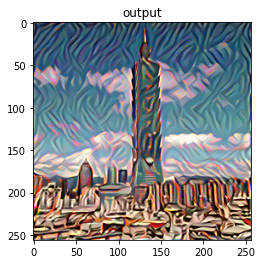

2000:
  sl: 11.739688, cl: 41.611694


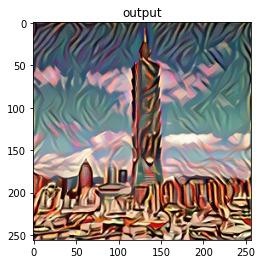

In [18]:
input_img = content_img.clone().detach().requires_grad_(True)
output_img = train_transfer(vgg_model,
                   vgg_normalization_mean, vgg_normalization_std,
                   content_img, style_img, input_img, num_steps=2000,
                   style_weight=1.0e4, content_weight=1)

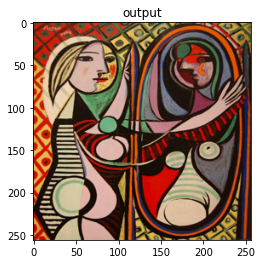

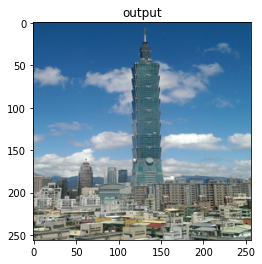

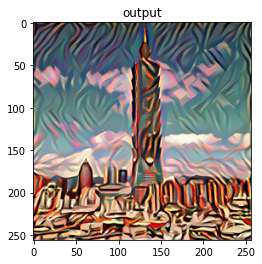

In [19]:
img_show(style_img, title="output")
img_show(content_img, title="output")
img_show(input_img, title="output")